In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import plotly.graph_objects as go


import pandas as pd
from scipy.io import readsav
from scipy.interpolate import UnivariateSpline

In [2]:
%run ../Functions.ipynb

# 3D position of the eruption

Call the tie-pointing triagulated data and GCS from the event. Take the average coordinates for each time.

In [3]:
#Triangulation coordinates
t304  = pd.read_csv('scc3_304.csv')

#Central coordinates of the triangulation
T304 = t304.groupby(['T']).agg({'lonC':['median','std'], 
                                'lat':['median','std'], 
                                'R':['median','std']})
T304.columns =['lonC','eLon', 'lat','eLat', 'R','eR']
T304.reset_index(inplace=True)
T304.lonC = np.mod(T304.lonC,360)

x304,y304,z304, ex, ey, ez = Sph2CartE(T304['R'],90-T304['lat'],
                                       T304['lonC'],T304['eR'],
                                       T304['eLat'],T304['eLon'])
ex = np.nan_to_num(ex)
ey = np.nan_to_num(ey)
ez = np.nan_to_num(ez)
ta304 = T304['T']

#Central coordinates of the GCS modeling

gcs  = pd.read_csv('gcs_param.csv')
n_gcs = len(gcs['T'])
gcc = np.ones([n_gcs,3,1])

for i in range(n_gcs):
    gcc[i] = RotCen(gcs['R'][i],gcs['k_fac'][i],gcs['lat'][i],gcs['lonC'][i],
                            gcs['Tilt'][i],gcs['Ne_tilt'][i])

gcc_R, gcc_lat, gcc_lon = Cart2Sph(gcc[:,0,0],gcc[:,1,0],gcc[:,2,0])

Field lines from PFSS

In [4]:
    #PFSS closed and positive open lines
lp  = pd.read_csv( 'openlinesp0.csv',header=None,names=['R', 'lat', 'lonC'],
                  sep='\s+',skip_blank_lines=False)
lc  = pd.read_csv('closedlines0.csv',header=None,names=['R', 'lat', 'lonC'],
                  sep='\s+',skip_blank_lines=False)

id0 = np.where((lp.R<1))[0]
lp['id'] = np.nan
lp.loc[id0, 'id'] = id0
lp['id'] = lp['id'].ffill()

id1 = np.where((lc.R<1))[0]
lc['id'] = np.nan
lc.loc[id1, 'id'] = id1
lc['id'] = lc['id'].ffill()

## Eruptive path

In [5]:
model_x = UnivariateSpline(t304['T']-t304['T'].min(),t304['X'])
model_y = UnivariateSpline(t304['T']-t304['T'].min(),t304['Y'])
model_z = UnivariateSpline(t304['T']-t304['T'].min(),t304['Z'])

t_fit = np.linspace(0, t304['T'].max()-t304['T'].min(), len(T304['T']))
x_fit = model_x(t_fit)
y_fit = model_y(t_fit)
z_fit = model_z(t_fit)

r_fit,th_fit,ph_fit = Cart2Sph(x_fit, y_fit, z_fit)

Add the GCS information and linearly fit the trajectory from last TP to GCS to add $2.5\,R_\odot$ coordinates

In [6]:
rf = np.append(r_fit[-1], gcc_R)
thf = np.append(th_fit[-1], gcc_lat)
phf = np.append(ph_fit[-1], gcc_lon)

ne = 5
model_th = np.poly1d(np.polyfit(rf,thf, 1))
model_ph = np.poly1d(np.polyfit(rf,phf, 1))


r_end = np.linspace(r_fit[-1], gcc_R[-1], ne)
th_end = model_th(r_end)
ph_end = model_ph(r_end)


x_end,y_end,z_end = Sph2Cart(2.5,90-model_th(2.5), model_ph(2.5))
x_end = np.append(x_fit,x_end)
y_end = np.append(y_fit,y_end)
z_end = np.append(z_fit,z_end)

In [7]:
rbow_cmap = plt.cm.rainbow(np.linspace(0.,1,len(ta304)))
rbow_plt = []
for k in range(len(ta304)):
    rbow_plt.append([k/(len(ta304)-1),'rgb'+str((int(rbow_cmap[k,0]*255), int(rbow_cmap[k,1]*255), int(rbow_cmap[k,2]*255)))])

# Magnetic information

Load magnetic field components and coordinates

In [8]:
coordR  = readsav('coordB.sav')['rix']
coordTh = readsav('coordB.sav')['theta']
coordPh = readsav('coordB.sav')['phi']
magr    = readsav('magvB.sav')['br']
magth   = readsav('magvB.sav')['bth']
magph   = readsav('magvB.sav')['bph']

Define the Lat-Long box of interest

In [9]:
iTh = np.where((np.degrees(coordTh)<=120) & (np.degrees(coordTh)>=30))[0]  # theta between 0-180
iPh = np.where((np.degrees(coordPh)<=200) & (np.degrees(coordPh)>=140))[0] # phi between 0-360

th2gr,rgr,ph2gr = np.meshgrid(coordTh[iTh], coordR, coordPh[iPh])
thgr = 90-np.degrees(th2gr)
phgr = np.degrees(ph2gr)
magri = magr[:,:,iPh][:,iTh,:]
magthi= magth[:,:,iPh][:,iTh,:]
magphi= magph[:,:,iPh][:,iTh,:]
B2 = magri**2+magthi**2+magphi**2
magB = np.sqrt(B2)

x_B, y_B, z_B = Sph2Cart(rgr.flatten(),90-thgr.flatten(),phgr.flatten())
B_x, B_y, B_z = vecSph2Cart(magri.flatten(),magthi.flatten(),magphi.flatten(),90-thgr.flatten(),phgr.flatten())

## Gradient path

In [10]:
# Find the initial indices
idr = np.argmin(np.abs( rgr[:, 0, 0] - r_fit[0]))
idt = np.argmin(np.abs(thgr[0, :, 0] - th_fit[0]))
idp = np.argmin(np.abs(phgr[0, 0, :] - ph_fit[0]))

# Initialize the result array
c_minE = np.array([[rgr[idr, 0, 0], thgr[0, idt, 0], phgr[0, 0, idp]]])

# Loop through the range and collect values
for i in range(1, min(92 - idr, 92)):
    A = magB[idr + i, idt - 1:idt + 2, idp - 1:idp + 2]
    pt, pp = np.unravel_index(A.argmin(), A.shape)
    
    idt += pt - 1
    idp += pp - 1
    
    new_row = [rgr[idr + i, 0, 0], thgr[0, idt, 0], phgr[0, 0, idp]]
    c_minE = np.vstack([c_minE, new_row])
    
    if idr == 91:
        break


## Topology path

$oa$ gives the coordinates of those closed field lines in a box defined by the latitude and longitude intervals. 
$id_{oa}$ gives the identity of the lines in the box. *new* gives the apex position of each closed field line, and the smaller one is selected for the topology path.

The procedure iterates from the new position, at the apex of the overlying field line, until there are no close field lines and we select the open field lines that should guide the eruption. The computation is alike using $ob$, and the max radius will be $2.5$ (upper boundary)

In [11]:
# Overlaying arcade
oa = np.where((( lc.lat  >= 89 - th_fit[0] ) & ( lc.lat  <= 91 - th_fit[0] ))   &   
             ( ( lc.lonC >= ph_fit[0] - 1    ) & ( lc.lonC <=  ph_fit[0] + 1   )) & 
               ( lc.R    >= r_fit[0]         ))[0]

id_oa = np.unique(lc.iloc[oa].id)
new = np.array([lc[lc.id == id].iloc[np.argmax(lc[lc.id == id].R)][:3] for id in id_oa])
d_tp = np.array([[r_fit[0], 90 - th_fit[0], ph_fit[0]], new[np.argmin(new[:, 0])]])


k = 2
while k < 100:
        # Overlay check for new conditions
    oa = np.where(
            ((lc.lat  >= d_tp[-1, 1] - 1) & (lc.lat  <= d_tp[-1, 1] + 1)) &
            ((lc.lonC >= d_tp[-1, 2] - 1) & (lc.lonC <= d_tp[-1, 2] + 1)) &
            ( lc.R    >  d_tp[-1, 0]))[0]

    if len(oa) == 0:
        print('Open at: ', k)
        ob = np.where(
                ((lp.lat  >= d_tp[-1, 1] - 2) & (lp.lat  <= d_tp[-1, 1] + 2)) &
                ((lp.lonC >= d_tp[-1, 2] - 2) & (lp.lonC <= d_tp[-1, 2] + 2)) &
                ( lp.R    >  d_tp[-1, 0]))[0]

        id_ob = np.unique(lp.iloc[ob].id)
        print('Final crossing: ', len(id_ob))
        
        if len(id_ob) == 0: break
            
        new = np.array([lp[lp.id == id].iloc[np.argmax(lp[lp.id == id].R)][:3] for id in id_ob])
        d_tp = np.append(d_tp, [new.mean(axis=0)], axis=0)
        break
    id_oa = np.unique(lc.iloc[oa].id)
    new = np.array([lc[lc.id == id].iloc[np.argmax(lc[lc.id == id].R)][:3] for id in id_oa])
    d_tp = np.append(d_tp, [new[np.argmin(new[:, 0])]], axis=0)
    k += 1


Open at:  13
Final crossing:  6


# Plot 3D

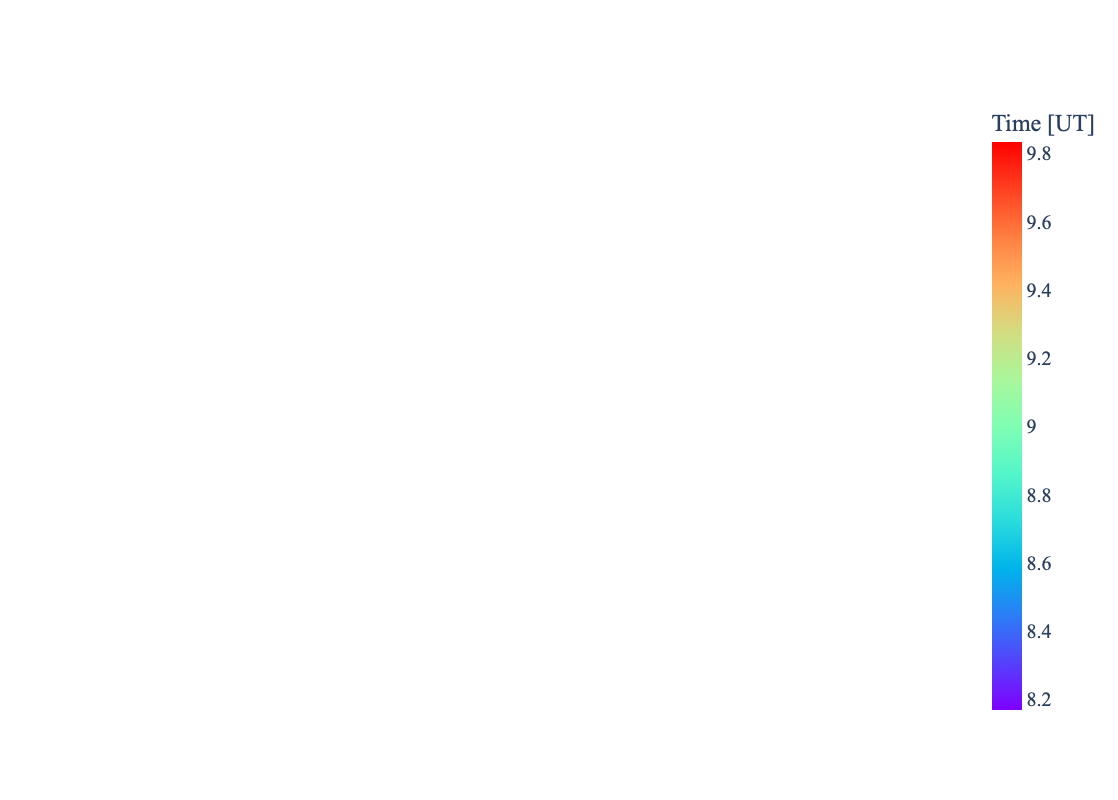

In [12]:
dm_r,dm_t,dm_p = Cart2Sph(x_end,y_end,z_end)
data1 =[ # Eruptive path and tracked coordinates
    go.Scatter3d( x=dm_r, y=dm_p, z=dm_t, mode='lines',
                     line=dict(color='black',width=4),
                     showlegend=False),

    go.Scatter3d( x=T304['R'], y=T304['lonC'], z=T304['lat'],mode='markers',
                         marker=dict(size=7,color=ta304,colorscale=rbow_plt,
                                    showscale=True,colorbar_title='Time [UT]',
                                    colorbar_tickfont_family='Times New Roman',
                                    colorbar_tickfont_size=20 ,
                                    colorbar_title_side='top',
                                    ),showlegend=False),
    # Gradient path
    go.Scatter3d( x=c_minE[:,0], y=c_minE[:,2], z=c_minE[:,1], mode='lines',
                      line=dict(color='mediumseagreen',dash='longdashdot',width=4),
                      showlegend=False),
    # Field lines
    go.Scatter3d(x=lc['R'],y=lc['lonC'],z=90-lc['lat'], mode='lines',
                     line=dict(color='grey',width=1),showlegend=False),
    # Topology path
    go.Scatter3d(x=d_tp[:,0],y=d_tp[:,2],z=90-d_tp[:,1], mode='markers+lines',
                    marker=dict(size=5,color='darkorange'),showlegend=False),
    ]

fig = go.Figure(data1,go.Layout(autosize=False,width=800,height=800))
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False,
                  bgcolor='lightgrey',aspectmode='auto' )

fig.show()